# GMRES WITH RESTART

In [1]:
import numpy as np
from numpy.linalg import qr

from functions import arnoldi, back_substitution

from scipy.sparse.linalg import lsqr
from scipy.linalg import solve_triangular

In [2]:
def GMRES_restarted(A, b, x0, k_max = None, restart = None, epsilon=1e-12):
    """
    Restarted Generalized Minimal RESidual method for solving linear systems.
    
    - Regular mode: when restart = None the full Krylov subspace is used to solve the problem. 
        This mode is guaranteed to find a solution (if one exists), but scales poorly.
        
    - Restarted mode: when restart = N then the Krylov subspace used by the solver is rebuilt every N steps. 
        This mode is not guaranteed to find a solution for certain intial conditions, but scales well.
    
    Parameters:
    -----------
    A : numpy.ndarray
        Coefficient matrix of the linear system.
        
    b : numpy.ndarray
        Right-hand side vector of the linear system.
        
    x0 : numpy.ndarray
        Initial guess for the solution.
        
    k_max : int
        Maximum number of iterations.
        
    restart : int, optional
        Number of iterations before restart. If None, the method will not restart.
        
    epsilon : float, optional
        Tolerance for convergence.
    
    Returns:
    --------
    numpy.ndarray
        Approximate solution to the linear system.
    """
    
    n = A.shape[0]
    
    if (k_max is None):
        k_max = n
        
    elif k_max > n:
        k_max = n
    
    r0 = b - A @ x0
    p0 = np.linalg.norm(r0)
    beta = p0
    pk = p0
    k = 0
    total_k = 0
    
    while pk > epsilon*p0 and total_k < k_max:
        
        k += 1
        total_k += 1
        
        V, H = arnoldi(A, b, x0, k) # Arnoldi algorithm to generate V_{k+1} and H_{K+1, K}
        
        Q, R = qr(H, mode = 'complete')
        
        pk = abs(beta*Q[0, k]) # Compute norm of residual vector
        
        yk = back_substitution(R[:-1, :] , beta*Q[0][:-1])
    
        xk = x0 + V[:, :-1]@yk # Compute the new approximation x0 + V_{k}y
        
        if restart is not None and k == restart:
            x0 = xk
            r0 = b - A @ x0
            p0 = np.linalg.norm(r0)
            beta = p0
            pk = p0
            k = 0
            
    return xk, pk, total_k

# Unit tests

## Test 1: Comparing against restarted gmres from scipy (csr format), $n=5,000$.

Some comments about SciPy's gmres implementation scipy.sparse.linalg.gmres(A, b, x0 = None, restart = None, maxiter = None)

- if restart == None then gmres does not restart.
- if restart is omitted, restart == min(20, n).

- if maxiter != None and restart != None then the total number of iterations is restart*maxiter.
- if maxiter != None and restart == None then the total number of iterations is maxiter
- if maxiter == None --> maxiter == 10*n (At least always plots this) for restart == None and for restart == value

However, the only way to use gmres without restart is to set: 'maxiter = 1' and 'restart = val'.

In [39]:
from scipy.sparse import random

n = 5000
density = 0.004  # 100k elements that are not 0

# Setting up random state
random_state = np.random.RandomState(73)

# Generating sparse matrix
A_sparse = random(n, n, density=density, format='csr', random_state = random_state)

# Generate random right-hand side vector and initial guess
b = random_state.rand(n)

In [40]:
# Convert sparse matrix to dense matrix
A_dense = A_sparse.toarray()

# Calculate condition number
condition_number = np.linalg.cond(A_dense)

# Format condition number in scientific notation
formatted_condition_number = "{:.2e}".format(condition_number)

print("Condition number of A:", formatted_condition_number)

Condition number of A: 4.68e+04


In [41]:
from scipy.sparse.linalg import spsolve

# Solve the linear system
x_exact = spsolve(A_sparse, b)

In [28]:
import numpy as np
from scipy.sparse.linalg import gmres
from time import time

x0 = np.zeros(n)

# Parameters
restart = 20
epsilon = 1e-8

# Solve using GMRES_restarted
start_time = time()
x_optimized, residual, iterations1 = GMRES_restarted(A_sparse, b, x0, k_max = None, restart = restart)
end_time = time()
print("Optimized GMRES_restarted Time:", end_time - start_time)

# Solve using SciPy's GMRES
start_time = time()
x_scipy, iterations2 = gmres(A_sparse, b, x0 = x0, restart = restart, maxiter = None, tol = epsilon)
end_time = time()
print("SciPy GMRES Time:", end_time - start_time)

# Check if solutions are close
print("Difference between our solution and SciPy solution:", np.linalg.norm(x_optimized - x_scipy))

print("\nDifference between our solution and the exact solution:", np.linalg.norm(x_optimized - x_exact))
residual_calculated1 = np.linalg.norm(A_sparse@x_optimized - b)
print("Residual calculated with Ax-b (restart = 20):", residual_calculated1)
print("Residual given by pk (restart = 20):", residual)
print("Number of iterations:", iterations1)

print("\nDifference between SciPy solution and the exact solution:", np.linalg.norm(x_scipy - x_exact))
residual_calculated1 = np.linalg.norm(A_sparse@x_scipy - b)
print("Residual calculated with Ax-b (restart = 20):", residual_calculated1)
print("Number of iterations:", iterations2)

Optimized GMRES_restarted Time: 18.183104038238525
SciPy GMRES Time: 307.93347001075745
Difference between our solution and SciPy solution: 6.165789893066034e-14

Difference between our solution and the exact solution: 2315.9671257267255
Residual calculated with Ax-b (restart = 20): 22.27423621262416
Residual given by pk (restart = 20): 22.27423621262416
Number of iterations: 5000

Difference between SciPy solution and the exact solution: 2315.9671257267255
Residual calculated with Ax-b (restart = 20): 22.274236212624164
Number of iterations: 50000


Note that we are not converging in this problem. The residual is around 22 both for our implementation and the Scipy implementation. 

## Test 2: Comparing SciPy implementation and our implementation in a matrix arised from a structural problem

https://sparse.tamu.edu/HB/bcsstk18

**Problem type:** structural problem - S STIFFNESS MATRIX arised from R.E.GINNA NUCLEAR POWER STATION

**Dimension:** 11,948 x 11,948

**Nonzero elements:** 149,090

**Condition number:** 3.459995e+11

In [117]:
import scipy.io
import scipy.sparse

# Load the .mtx file
A = scipy.io.mmread("data/bcsstk18.mtx")

# Convert the matrix to CRS format
A = scipy.sparse.csr_matrix(A)

b = np.ones(A.shape[0])

x0 = np.zeros(b.size)

maxiter = 10000
restart = 20

start_time = time()
x, iterations = gmres(A, b, x0, restart = 20, maxiter = maxiter/restart)
residual_calculated1 = np.linalg.norm(A@x - b)
end_time = time()
print("SciPy GMRES Time:", end_time - start_time)

print(f"Calculated Scipy residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated1}")

start_time = time()
x = GMRES_restarted(A, b, x0, k_max = 10000, restart = 20)[0]
residual_calculated2 = np.linalg.norm(A@x - b)
end_time = time()
print("Optimized GMRES_restarted Time:", end_time - start_time)

print(f"Our implementation residual with Ax-b (max_iterations = {maxiter}, restart = {restart}): {residual_calculated2}")

SciPy GMRES Time: 6.991647243499756
Calculated Scipy residual with Ax-b (max_iterations = 10000, restart = 20): 70.57320010911614
Optimized GMRES_restarted Time: 73.49128222465515
Our implementation residual with Ax-b (max_iterations = 10000, restart = 20): 70.57320020880756


## Test 3: Poisson problem in the unit square $\Omega = [0,1]^2$ with $x=0$ in $\partial\Omega$.

In [79]:
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [97]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.sparse.linalg import spsolve

N = 100

A, f = discretise_poisson(N)

A.shape, f.shape

((10000, 10000), (10000,))

In [98]:
# Convert sparse matrix to dense matrix
A_dense = A.toarray()

# Calculate condition number
condition_number = np.linalg.cond(A_dense)

# Format condition number in scientific notation
formatted_condition_number = "{:.2e}".format(condition_number)

print("Condition number of A:", formatted_condition_number)

Condition number of A: 4.22e+05


Do not seet a maximum number of iterations: it will run until the dimension of $A$. Maybe we should increase the number of iterations as it does not converge in $n$ iterations as it should in exact arithmetics.

In [99]:
x0 = np.zeros(N*N)

# Parameters
k_max = 100
epsilon = 1e-12

x1, _, _= GMRES_restarted(A, f, x0, k_max, restart= 10)

residual = np.linalg.norm(A@x1 - f)

print("Our implementation residual with Ax-b (restart = 10):", residual)

x2, _, _= GMRES_restarted(A, f, x0, k_max, restart= 20)

residual = np.linalg.norm(A@x2 - f)

print("\nOur implementation residual with Ax-b (restart = 20):", residual)

x3, _, _= GMRES_restarted(A, f, x0, k_max, restart= 50)

residual = np.linalg.norm(A@x3 - f)

print("\nOur implementation residual with Ax-b (restart = 50):", residual)

Our implementation residual with Ax-b (restart = 10): 47.97977620135408

Our implementation residual with Ax-b (restart = 20): 30.403591750727188

Our implementation residual with Ax-b (restart = 50): 11.18081205072279


In [ ]:
x0 = np.zeros(N*N)

# Parameters
k_max = 1000
epsilon = 1e-12

x1, _, _= GMRES_restarted(A, f, x0, k_max, restart= 10)

residual = np.linalg.norm(A@x1 - f)

print("Our implementation residual with Ax-b (restart = 10):", residual)

x2, _, _= GMRES_restarted(A, f, x0, k_max, restart= 20)

residual = np.linalg.norm(A@x2 - f)

print("\nOur implementation residual with Ax-b (restart = 20):", residual)

x3, _, _= GMRES_restarted(A, f, x0, k_max, restart= 50)

residual = np.linalg.norm(A@x3 - f)

print("\nOur implementation residual with Ax-b (restart = 50):", residual)

x4, _, _= GMRES_restarted(A, f, x0, k_max, restart= 100)

residual = np.linalg.norm(A@x4 - f)

print("\nOur implementation residual with Ax-b (restart = 50):", residual)

## Test 4: Comparing different restart values

Residual without restarting and 200 iterations (dim A): 5.4809140537552154e-14


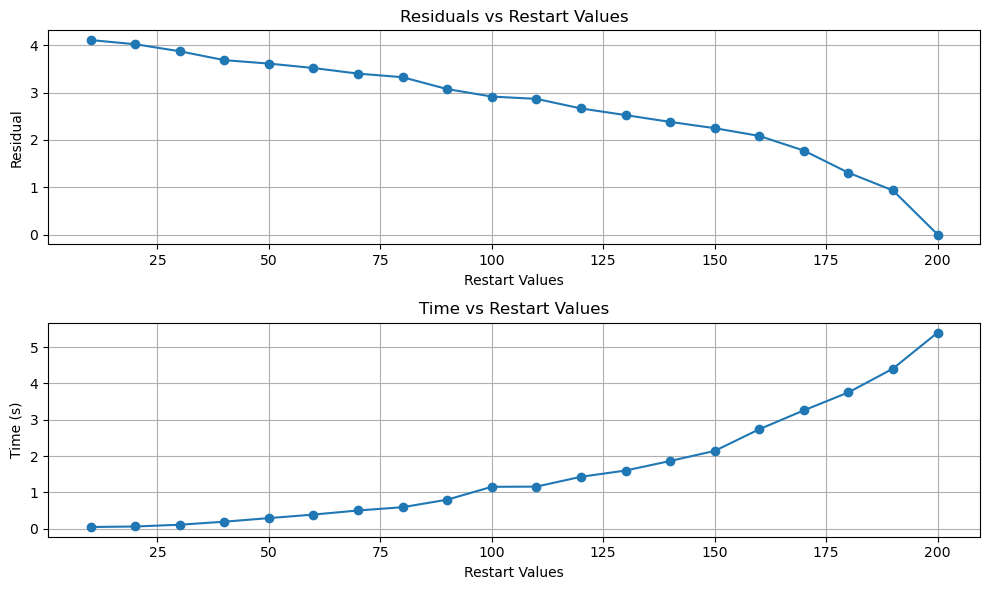

In [21]:
import numpy as np
from scipy.sparse import random
import matplotlib.pyplot as plt
import time

# Define the GMRES_restarted function here

def generate_sparse_matrix(n, density=0.1):
    """
    Generate a random sparse matrix.
    
    Parameters:
    -----------
    n : int
        Size of the matrix.
        
    density : float, optional
        Density of non-zero elements.
        
    Returns:
    --------
    scipy.sparse.csr_matrix
        Random sparse matrix.
    """
    return random(n, n, density = density, format='csr')

def compare_restart_values(n, density=0.1, k_max=None, restart_values=[None, 5, 10, 20], epsilon=1e-12):
    """
    Compare different restart values for GMRES restarted method.
    
    Parameters:
    -----------
    n : int
        Size of the matrix.
        
    density : float, optional
        Density of non-zero elements in the sparse matrix.
        
    k_max : int, optional
        Maximum number of iterations.
        
    restart_values : list, optional
        List of restart values to compare.
        
    epsilon : float, optional
        Tolerance for convergence.
    """
    A = generate_sparse_matrix(n, density)
    b = np.random.rand(n)
    x0 = np.zeros_like(b)
    
    residuals = []
    times = []
    
    for restart in restart_values:
        start_time = time.time()
        xk, residual, total_iterations = GMRES_restarted(A, b, x0, k_max=k_max, restart=restart, epsilon=epsilon)
        end_time = time.time()
        residuals.append(residual)
        times.append(end_time - start_time)
    
    sol, _, _ = GMRES_restarted(A, b, x0, k_max = None, restart=None, epsilon = epsilon)
    residual = np.linalg.norm(A@sol - b)
    print("Residual without restarting and 200 iterations (dim A):", residual)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Plot for residuals
    plt.subplot(2, 1, 1)
    plt.plot(restart_values, residuals, marker='o')
    plt.title('Residuals vs Restart Values')
    plt.xlabel('Restart Values')
    plt.ylabel('Residual')
    plt.grid(True)
    
    # Plot for time
    plt.subplot(2, 1, 2)
    plt.plot(restart_values, times, marker='o')
    plt.title('Time vs Restart Values')
    plt.xlabel('Restart Values')
    plt.ylabel('Time (s)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

compare_restart_values(200, density = 0.1, k_max = None, restart_values=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200])

# Comments

- Test1 does not converge. Moreover, it gets stuck and it does not improve even though we perform more iterations
- Test2 converges to the residual so slowly. One can play with the parameters and see that everytime the residual decreases, however it takes too long if set the restart parameter to large values. **We can also see that our implementation is way more slower than the SciPy's one.**

Due to the ill-conditioning of the original matrix we were not able to converge in some of the tests. Let's try to improve the condition number of our linear system by preconditioning it --> **PRECONDITIONED GMRES**